This is dataset retrieved from http://kilimodata.developlocal.org/dataset/kenya-maize-production-by-counties

It shows the maize production in Kenya in 2018 by counties.

Key goals of the project:

1. Clean the data 
2. Do some Exploratory Data Analysis
3. Viz counties with most tonnage
4. Viz counties that get more value from thier production
5. Use addresses available to create geotags, and create new columns for latitudes & longitudes
6. Use Folium to viz the regions
7. Bonus: Build a Mapbox scatter plot that will show tonnage when hovering map.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [2]:
#import csv file
df= pd.read_csv("E:\DS projects and dataset\Kenya-maize-production-and-value-by-counties-2018.csv")
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha) Quantity (Ton) Value (KShs)
0  BARINGO  Baringo central  Long Rains     8,100         10,200  255,000,000
1  BARINGO    Baringo North  Long Rains     4,700          5,660  141,500,250
2  BARINGO    Baringo South  Long Rains     6,080         11,932  282,600,000
3  BARINGO       East Pokot  Long Rains     1,450          1,747   96,175,000
4  BARINGO          Mogotio  Long Rains     5,034          5,075  261,500,000

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   COUNTY          582 non-null    object
 1   SUBCOUNTY       582 non-null    object
 2   Season          582 non-null    object
 3   Area (Ha)       582 non-null    object
 4   Quantity (Ton)  582 non-null    object
 5   Value (KShs)    582 non-null    object
dtypes: object(6)
memory usage: 27.4+ KB


In [4]:
#checking for null values
df.isnull().sum()        

COUNTY            0
SUBCOUNTY         0
Season            0
Area (Ha)         0
Quantity (Ton)    0
Value (KShs)      0
dtype: int64

No missing values as seen above

In [5]:
#convert Quantity (Ton) column to float
df["Quantity (Ton)"] = df["Quantity (Ton)"].str.replace("," , "", regex=False).astype(float)

In [6]:
#convert Value (KShs) column to float
df["Value (KShs)"] = df["Value (KShs)"].str.replace("," , "", regex=False).astype(float)

In [7]:
#create a new column called location
df["location"] = df["COUNTY"] + "," + df["SUBCOUNTY"]
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha)  Quantity (Ton)  \
0  BARINGO  Baringo central  Long Rains     8,100         10200.0   
1  BARINGO    Baringo North  Long Rains     4,700          5660.0   
2  BARINGO    Baringo South  Long Rains     6,080         11932.0   
3  BARINGO       East Pokot  Long Rains     1,450          1747.0   
4  BARINGO          Mogotio  Long Rains     5,034          5075.0   

   Value (KShs)                 location  
0   255000000.0  BARINGO,Baringo central  
1   141500250.0    BARINGO,Baringo North  
2   282600000.0    BARINGO,Baringo South  
3    96175000.0       BARINGO,East Pokot  
4   261500000.0          BARINGO,Mogotio

The location column concatenates county and subcounty columns to create the full address

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COUNTY          582 non-null    object 
 1   SUBCOUNTY       582 non-null    object 
 2   Season          582 non-null    object 
 3   Area (Ha)       582 non-null    object 
 4   Quantity (Ton)  582 non-null    float64
 5   Value (KShs)    582 non-null    float64
 6   location        582 non-null    object 
dtypes: float64(2), object(5)
memory usage: 32.0+ KB


In [9]:
#Some descriptive statistics
df.describe()

Quantity (Ton)  Value (KShs)
count      582.000000  5.820000e+02
mean      6896.548110  1.635608e+08
std      15667.281207  3.360339e+08
min          0.000000  0.000000e+00
25%         73.500000  2.007500e+06
50%       2073.000000  5.062600e+07
75%       6695.750000  1.675451e+08
max     160600.000000  3.170150e+09

In [11]:
#Grouping by county and sorting them by tonnage
df_ton = df.groupby("COUNTY")["Quantity (Ton)"].mean().sort_values(ascending=False)
df_ton.head()

COUNTY
TRANS NZOIA    54819.700000
UASIN GISHU    33788.416667
NANDI          22399.750000
NAROK          17358.916667
BUNGOMA        16415.666667
Name: Quantity (Ton), dtype: float64

Trans Nzoia produces the most maize by tonnage; garissa the least

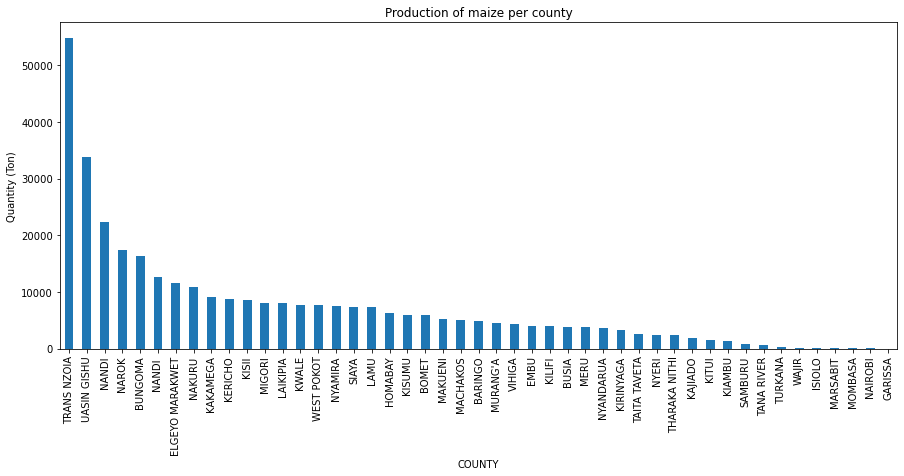

In [12]:
#Plotting using a bar graph

fig, ax = plt.subplots(figsize=(15, 6))    #blank canvas
df_ton.plot(kind="bar", xlabel= "COUNTY", ylabel= "Quantity (Ton)", title= "Production of maize per county", ax=ax);

In [13]:
#Grouping by county and sorting them by value

df_value = df.groupby("COUNTY")["Value (KShs)"].mean().sort_values(ascending=False)

df_value.head()

COUNTY
UASIN GISHU    9.511050e+08
TRANS NZOIA    6.947671e+08
NAROK          5.089256e+08
NANDI          4.086111e+08
NANDI          3.622594e+08
Name: Value (KShs), dtype: float64

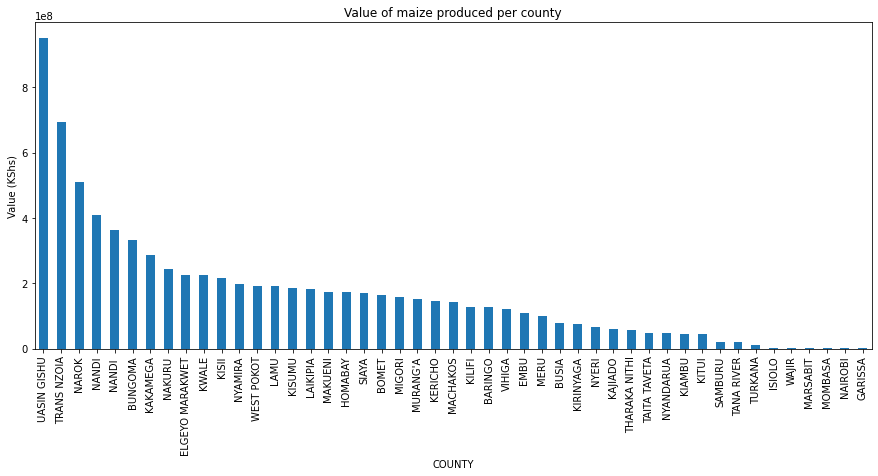

In [14]:
#Plotting value using a bar graph

fig, ax = plt.subplots(figsize=(15, 6))   
df_value.plot(kind="bar", xlabel= "COUNTY", ylabel= "Value (KShs)", title= "Value of maize produced per county", ax=ax);

Uasin Gishu get more value from its maize, garissa the least

In [15]:
#total maize produced in 2018
df["Quantity (Ton)"].sum()

4013791.0

MAPPING

In [16]:
from geopy.extra.rate_limiter import RateLimiter  #import a geocoding lib
from geopy.geocoders import Nominatim     #import Nominatim
import folium
import plotly.express as px  #viz

In [17]:
#Testing with an address

locator = Nominatim(user_agent="myGeocoder")
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")   #add a timeout
location_ex= geolocator.geocode("Nairobi")        #put test address
print(location_ex)
print((location_ex.latitude, location_ex.longitude))

Nairobi, Kenya
(-1.30326415, 36.826384099341595)


In [19]:
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha)  Quantity (Ton)  \
0  BARINGO  Baringo central  Long Rains     8,100         10200.0   
1  BARINGO    Baringo North  Long Rains     4,700          5660.0   
2  BARINGO    Baringo South  Long Rains     6,080         11932.0   
3  BARINGO       East Pokot  Long Rains     1,450          1747.0   
4  BARINGO          Mogotio  Long Rains     5,034          5075.0   

   Value (KShs)                 location  
0   255000000.0  BARINGO,Baringo central  
1   141500250.0    BARINGO,Baringo North  
2   282600000.0    BARINGO,Baringo South  
3    96175000.0       BARINGO,East Pokot  
4   261500000.0          BARINGO,Mogotio

In [20]:
#creating a column containing address and geocodes
df["address"]= df["location"].apply(geolocator.geocode) 

In [21]:
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha)  Quantity (Ton)  \
0  BARINGO  Baringo central  Long Rains     8,100         10200.0   
1  BARINGO    Baringo North  Long Rains     4,700          5660.0   
2  BARINGO    Baringo South  Long Rains     6,080         11932.0   
3  BARINGO       East Pokot  Long Rains     1,450          1747.0   
4  BARINGO          Mogotio  Long Rains     5,034          5075.0   

   Value (KShs)                 location  \
0   255000000.0  BARINGO,Baringo central   
1   141500250.0    BARINGO,Baringo North   
2   282600000.0    BARINGO,Baringo South   
3    96175000.0       BARINGO,East Pokot   
4   261500000.0          BARINGO,Mogotio   

                                             address  
0  (Baringo Central IEBC office, Kabarnet Road, K...  
1                                               None  
2  (IEBC-Baringo South Office, C51J1, Marigat, Ba...  
3                                               None  
4  (Mogotio, Baringo, Kenya, (-0.022313, 35.96183...

In [22]:
df["address"].head()

0    (Baringo Central IEBC office, Kabarnet Road, K...
1                                                 None
2    (IEBC-Baringo South Office, C51J1, Marigat, Ba...
3                                                 None
4    (Mogotio, Baringo, Kenya, (-0.022313, 35.96183...
Name: address, dtype: object

In [23]:
#checking for null values
df.isnull().sum()

COUNTY              0
SUBCOUNTY           0
Season              0
Area (Ha)           0
Quantity (Ton)      0
Value (KShs)        0
location            0
address           212
dtype: int64

Address contains some null values.

In [24]:
#remove null values
df.dropna(inplace=True)  

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 581
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COUNTY          370 non-null    object 
 1   SUBCOUNTY       370 non-null    object 
 2   Season          370 non-null    object 
 3   Area (Ha)       370 non-null    object 
 4   Quantity (Ton)  370 non-null    float64
 5   Value (KShs)    370 non-null    float64
 6   location        370 non-null    object 
 7   address         370 non-null    object 
dtypes: float64(2), object(6)
memory usage: 26.0+ KB


In [28]:
# Split address column and create address_txt and lat-lon columns
df[["address_txt", "lat-lon"]]= pd.DataFrame(df["address"].tolist(), index=df.index)

In [29]:
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha)  Quantity (Ton)  \
0  BARINGO  Baringo central  Long Rains     8,100         10200.0   
2  BARINGO    Baringo South  Long Rains     6,080         11932.0   
4  BARINGO          Mogotio  Long Rains     5,034          5075.0   
5  BARINGO    Eldama Ravine  Long Rains    12,248         23780.0   
9    BOMET           Konoin  Long Rains     1,950          3861.0   

   Value (KShs)                 location  \
0   255000000.0  BARINGO,Baringo central   
2   282600000.0    BARINGO,Baringo South   
4   261500000.0          BARINGO,Mogotio   
5   475592000.0    BARINGO,Eldama Ravine   
9   108108000.0             BOMET,Konoin   

                                             address  \
0  (Baringo Central IEBC office, Kabarnet Road, K...   
2  (IEBC-Baringo South Office, C51J1, Marigat, Ba...   
4  (Mogotio, Baringo, Kenya, (-0.022313, 35.96183...   
5  (Eldama Ravine, Baringo, Kenya, (0.035947, 35....   
9   (Konoin, Bomet, Kenya, (-0.5790116, 35.5777028))   

                                         address_txt                   lat-lon  
0  Baringo Central IEBC office, Kabarnet Road, Ka...   (0.4923519, 35.7448791)  
2  IEBC-Baringo South Office, C51J1, Marigat, Bar...      (0.471523, 35.98473)  
4                            Mogotio, Baringo, Kenya   (-0.022313, 35.9618378)  
5                      Eldama Ravine, Baringo, Kenya    (0.035947, 35.7126099)  
9                               Konoin, Bomet, Kenya  (-0.5790116, 35.5777028)

In [35]:
#split lat-lon column , splitting a Series
df[["lat", "lon"]]=pd.DataFrame(df["lat-lon"].values.tolist(), index=df.index)

In [36]:
df.head()

COUNTY        SUBCOUNTY      Season Area (Ha)  Quantity (Ton)  \
0  BARINGO  Baringo central  Long Rains     8,100         10200.0   
2  BARINGO    Baringo South  Long Rains     6,080         11932.0   
4  BARINGO          Mogotio  Long Rains     5,034          5075.0   
5  BARINGO    Eldama Ravine  Long Rains    12,248         23780.0   
9    BOMET           Konoin  Long Rains     1,950          3861.0   

   Value (KShs)                 location  \
0   255000000.0  BARINGO,Baringo central   
2   282600000.0    BARINGO,Baringo South   
4   261500000.0          BARINGO,Mogotio   
5   475592000.0    BARINGO,Eldama Ravine   
9   108108000.0             BOMET,Konoin   

                                             address  \
0  (Baringo Central IEBC office, Kabarnet Road, K...   
2  (IEBC-Baringo South Office, C51J1, Marigat, Ba...   
4  (Mogotio, Baringo, Kenya, (-0.022313, 35.96183...   
5  (Eldama Ravine, Baringo, Kenya, (0.035947, 35....   
9   (Konoin, Bomet, Kenya, (-0.5790116, 35.5777028))   

                                         address_txt  \
0  Baringo Central IEBC office, Kabarnet Road, Ka...   
2  IEBC-Baringo South Office, C51J1, Marigat, Bar...   
4                            Mogotio, Baringo, Kenya   
5                      Eldama Ravine, Baringo, Kenya   
9                               Konoin, Bomet, Kenya   

                    lat-lon       lat        lon  
0   (0.4923519, 35.7448791)  0.492352  35.744879  
2      (0.471523, 35.98473)  0.471523  35.984730  
4   (-0.022313, 35.9618378) -0.022313  35.961838  
5    (0.035947, 35.7126099)  0.035947  35.712610  
9  (-0.5790116, 35.5777028) -0.579012  35.577703

lat contains latitudes; lon contains longitude

Choosing a centrepoint for our map.

Inputting Nairobi as our centrepoint with coordinates 1.2921° S, 36.8219° E

In [37]:
my_map = folium.Map(location = (1.2921, 36.8219), zoom_start=5)

display(my_map)

In [38]:
#adding other geolocations

for index, row in df.iterrows():
    folium.Marker(location=(row["lat"], row["lon"])).add_to(my_map)
    
display(my_map)    

BUILDING A MAPBOX SCATTER PLOT

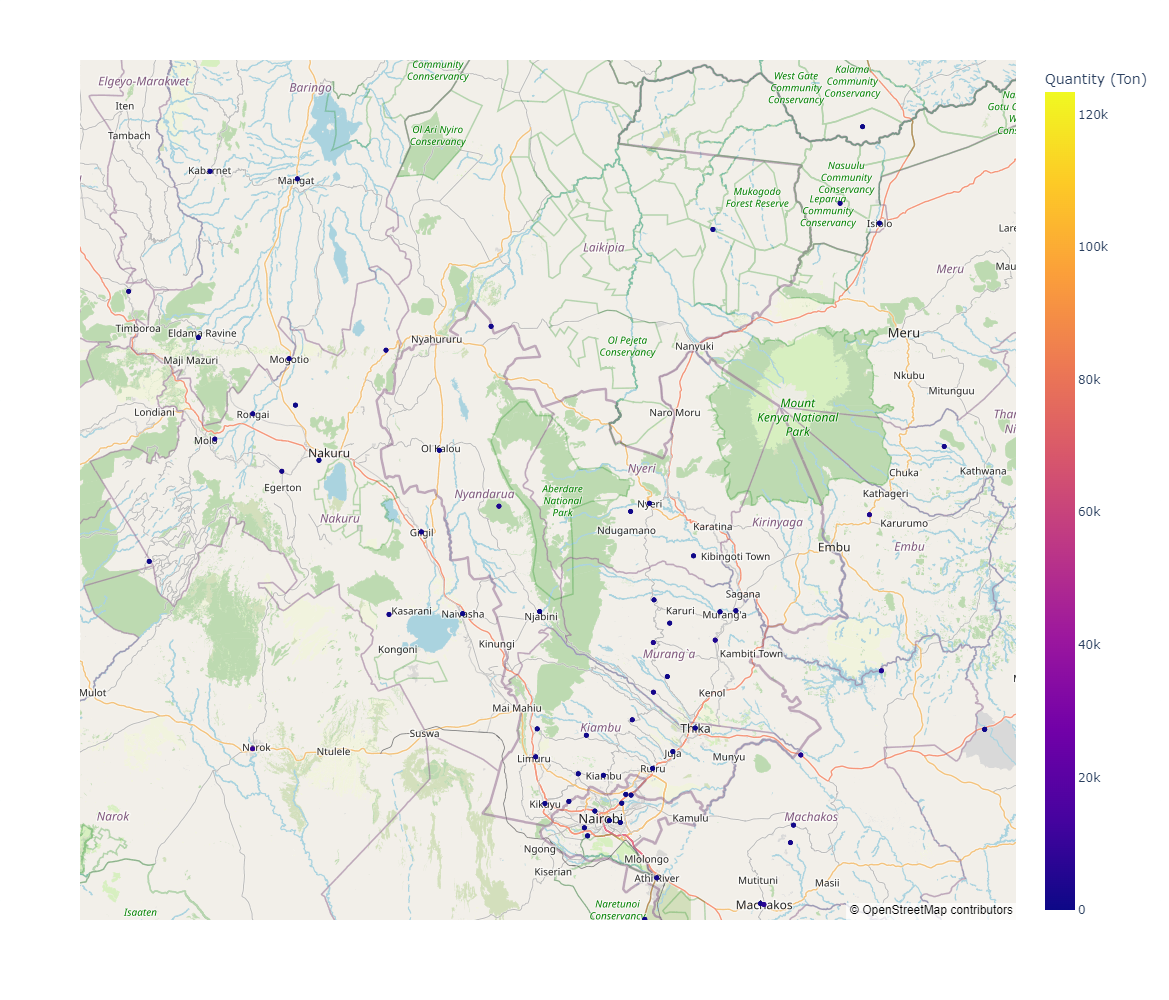

In [40]:
#Mapbox scatter plot

fig= px.scatter_mapbox(
    df,
    lat= "lat",
    lon = "lon",
    color= "Quantity (Ton)",
    width= 1000,
    height= 1000,
    hover_data = ["Quantity (Ton)"]  #display tonnage when hovering map
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()
    


